# RE Forecasting: Model Fitting

Steps (per energy type):
1. Prepare data
    - Load data (Dfs holding feature and target timeseries)
    - Add datetime features
    - Create train/test split
    - Fit base model (pre tuning) to determine feature importance
2. Run cross-validated grid search to optimize parameters
    - Run grid search
    - Predict held out test-data and get score
    - Plot predictions

Some thoughts:

1. I am using XGBoost with decision trees. This has some important implications:
    - XGBoost can handle missing values (has some smart imputation strategies) 
    - XGBoost with decision trees is not sensitive to data scaling
    
    Both aspects have to be reconsidered if switching to a different modelling approach!

2. Some of the weather features are highly correlated. However, my problem is rather too little information (due to the averaging across clusters) than too much and since the weather data per location should be precise, I am not too worried about excessive noise. Therefore, I will not run PCA on the features at this point and instead, I will use all features available (and only exclude features based on their importance in the model).

### Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt, timedelta
import os

# modelling
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from REForecasting import *

# Enable module reload after changes 
%load_ext autoreload
%aimport REForecasting

### Set parameters etc.

In [2]:
# Time period of historical data included in the data set
start_date = "20180801"
end_date = "20230801"

# Directories 
fpath_data = f"data/{start_date}-{end_date}"
fpath_models = f"models/{start_date}-{end_date}"
if not os.path.isdir(fpath_models):
    os.makedirs(fpath_models)

# Date defining train and test split
split_date = "2023-07-01" # use last month of data as test set

# Parameter grid for Grid Search
params = {
    "n_estimators": [1000, 1500, 2000],
    "learning_rate": [0.01, 0.005, 0.001],
    "max_depth": [4, 6, 8],
}

# Fit models

## Solar

In [3]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


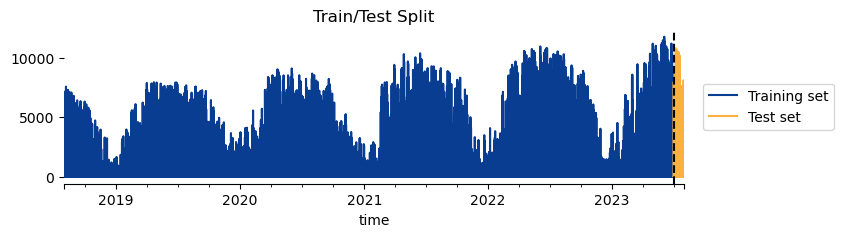

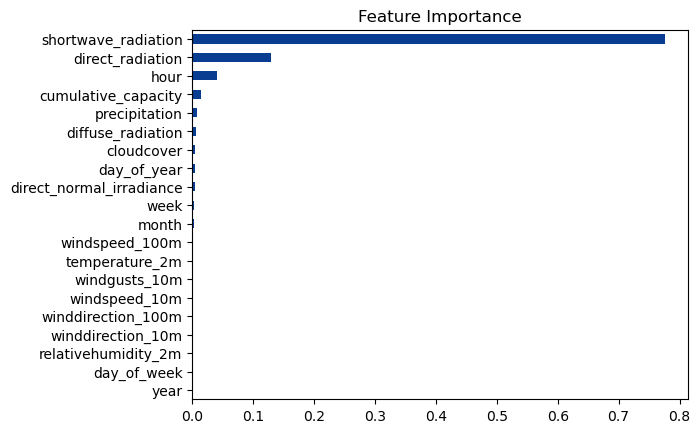

In [4]:
# Load data
solar_df = pd.read_parquet(f"{fpath_data}/solar_data_final_100_clusters_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/solar_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    solar_fi = pd.read_parquet(fi_path)
    solar_train, solar_test, solar_base_xgb, solar_fi = data_prep(solar_df, split_date, fit_base=False, fi=solar_fi)
else:
    solar_train, solar_test, solar_base_xgb, solar_fi = data_prep(solar_df, split_date)
    solar_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

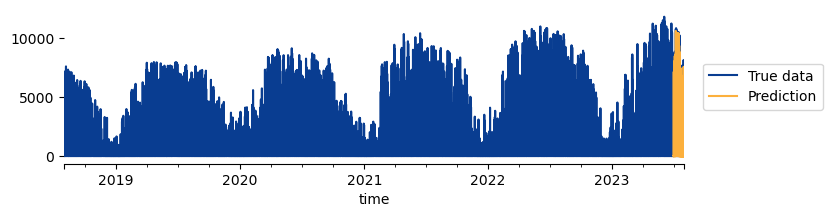

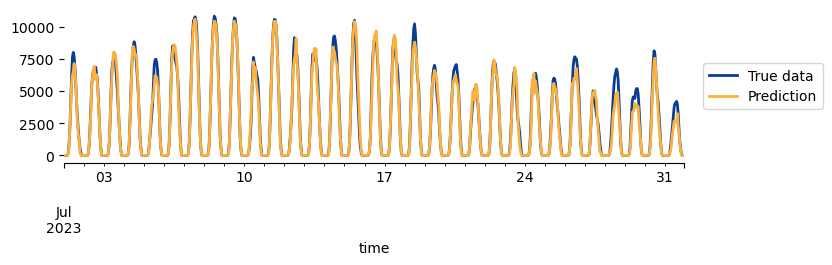

In [5]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
solar_features = [ 'shortwave_radiation', 'direct_radiation', 'hour',
                   'cumulative_capacity', 'precipitation', 'diffuse_radiation',
                   'cloudcover', 'day_of_year', 'direct_normal_irradiance', 'week',
                   'month', 'year']

mname = "solar_xgboost_cv_5years_100clusters"

if LOAD_FROM_FILE:
    solar_xgb = xgb.XGBRegressor()
    solar_xgb.load_model(f"{fpath_models}/{mname}.json")
    solar_df_pred = make_forecast(solar_test, solar_xgb, true_df=solar_df, plot_start=split_date, plot_end=end_date)
else:
    solar_xgb, solar_test, solar_rmse = run_grid_search(solar_df, solar_train, solar_test, solar_features, params)
    solar_xgb.save_model(f"{fpath_models}/{mname}.json")

## Wind - onshore

In [6]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


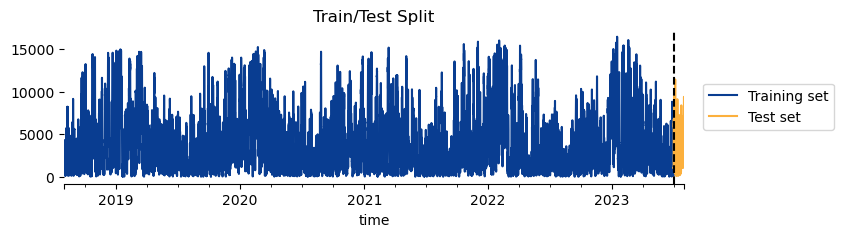

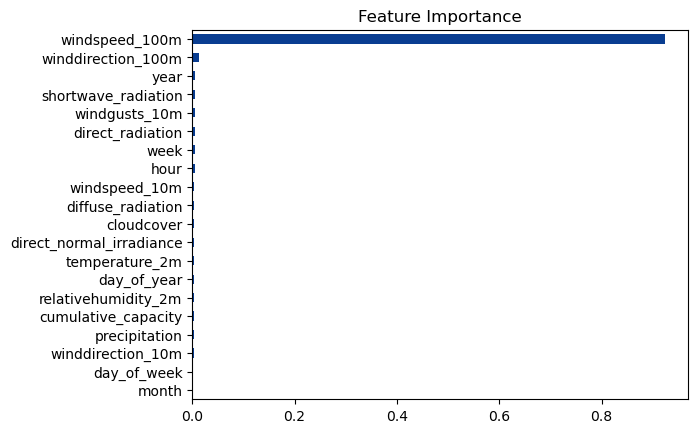

In [7]:
# Load data
onshore_df = pd.read_parquet(f"{fpath_data}/wind_onshore_data_final_100_clusters_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/wind_onshore_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    onshore_fi = pd.read_parquet(fi_path)
    onshore_train, onshore_test, onshore_base_xgb, onshore_fi = data_prep(onshore_df, split_date, fit_base=False, fi=onshore_fi)
else:
    onshore_train, onshore_test, onshore_base_xgb, onshore_fi = data_prep(onshore_df, split_date)
    onshore_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

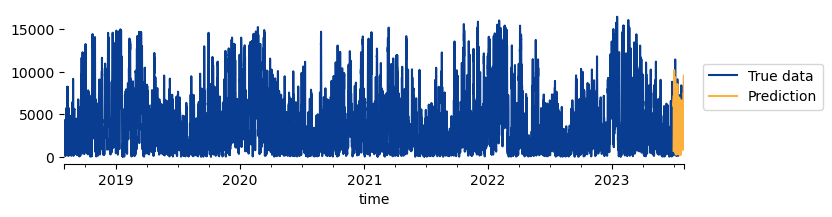

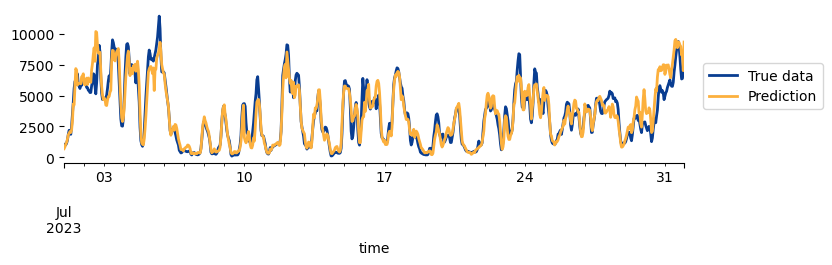

In [8]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
onshore_features = ['windspeed_100m', 'winddirection_100m', 'year', 'shortwave_radiation',
                    'windgusts_10m', 'direct_radiation', 'week', 'hour', 'windspeed_10m', 'cumulative_capacity']

mname = "wind_onshore_xgboost_cv_5years_100clusters"

if LOAD_FROM_FILE:
    onshore_xgb = xgb.XGBRegressor()
    onshore_xgb.load_model(f"{fpath_models}/{mname}.json")
    onshore_df_pred = make_forecast(onshore_test, onshore_xgb, true_df=onshore_df, plot_start=split_date, plot_end=end_date)
else:
    onshore_xgb, onshore_test, onshore_rmse = run_grid_search(onshore_df, onshore_train, onshore_test, onshore_features, params)
    onshore_xgb.save_model(f"{fpath_models}/{mname}.json")

## Wind offshore

In [9]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


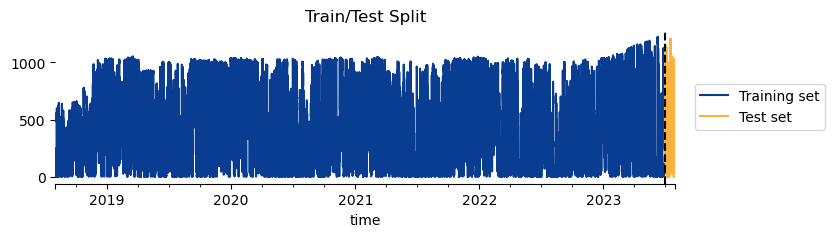

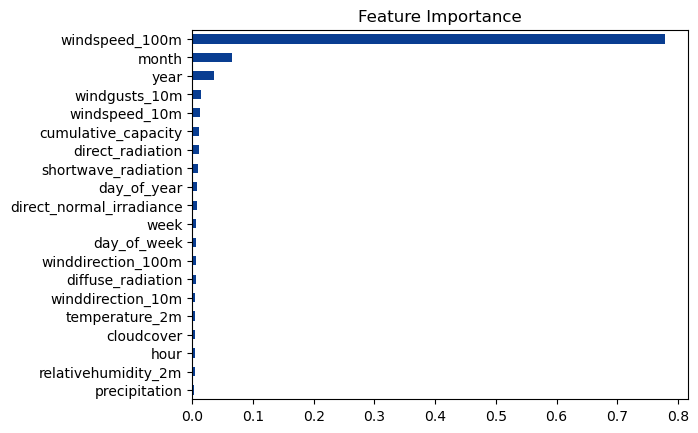

In [10]:
# Load data
offshore_df = pd.read_parquet(f"{fpath_data}/wind_offshore_data_final_6_clusters_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/wind_offshore_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    offshore_fi = pd.read_parquet(fi_path)
    offshore_train, offshore_test, offshore_base_xgb, offshore_fi = data_prep(offshore_df, split_date, fit_base=False, fi=offshore_fi)
else:
    offshore_train, offshore_test, offshore_base_xgb, offshore_fi = data_prep(offshore_df, split_date)
    offshore_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

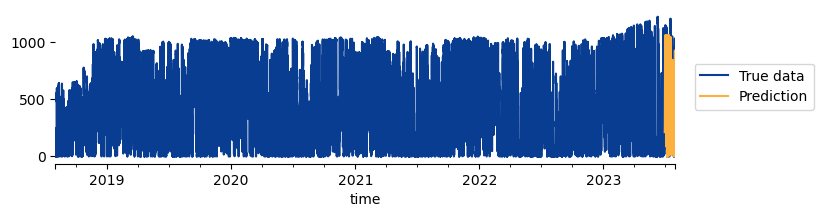

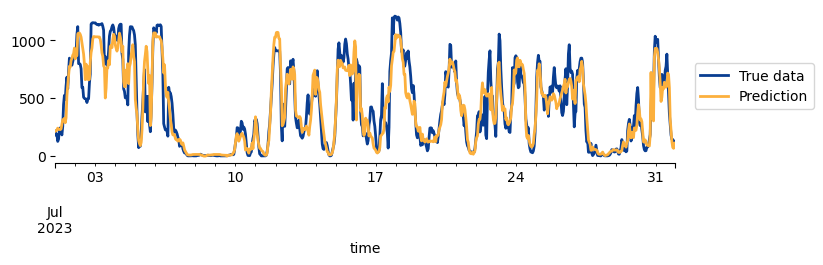

In [11]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
offshore_features = ['windspeed_100m', 'month', 'year', 'windgusts_10m', 'windspeed_10m',
                     'cumulative_capacity', 'direct_radiation', 'shortwave_radiation',
                     'day_of_year', 'direct_normal_irradiance', 'week', 'day_of_week',
                     'winddirection_100m']

mname = "wind_offshore_xgboost_cv_5years_6clusters"

if LOAD_FROM_FILE:
    offshore_xgb = xgb.XGBRegressor()
    offshore_xgb.load_model(f"{fpath_models}/{mname}.json")
    offshore_df_pred = make_forecast(offshore_test, offshore_xgb, true_df=offshore_df, plot_start=split_date, plot_end=end_date)
else:
    offshore_xgb, offshore_test, offshore_rmse = run_grid_search(offshore_df, offshore_train, offshore_test, offshore_features, params)
    offshore_xgb.save_model(f"{fpath_models}/{mname}.json")

## Consumption

In [12]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


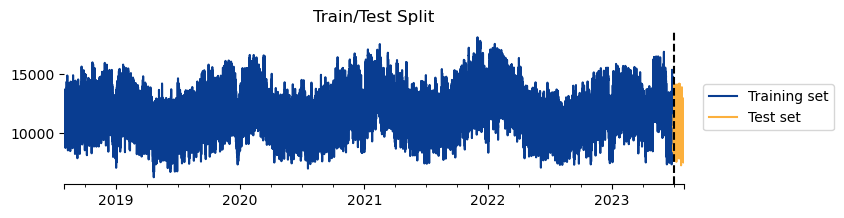

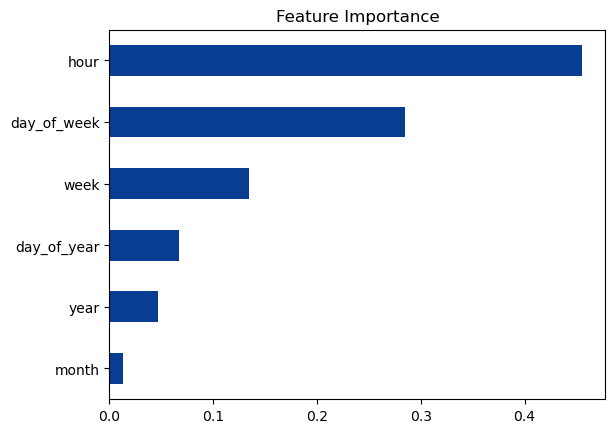

In [13]:
# Load data
consumption_df = pd.read_parquet(f"{fpath_data}/consumption_data_final_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/consumption_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    consumption_fi = pd.read_parquet(fi_path)
    consumption_train, consumption_test, consumption_base_xgb, consumption_fi = data_prep(consumption_df, split_date, fit_base=False, fi=consumption_fi, target="total_consumption")
else:
    consumption_train, consumption_test, consumption_base_xgb, consumption_fi = data_prep(consumption_df, split_date, target="total_consumption")
    consumption_fi.to_parquet(fi_path)

#### Intermezzo: Explore association of consumption with various datetime features

In [14]:
def plot_consumption(df, dt_feature):
    fig, ax = plt.subplots(figsize=(6,2))
    sns.boxplot(data=df, x=dt_feature, y="total_consumption", palette="Blues")
    ax.set_title(f"Total electricity consumption by {dt_feature}")

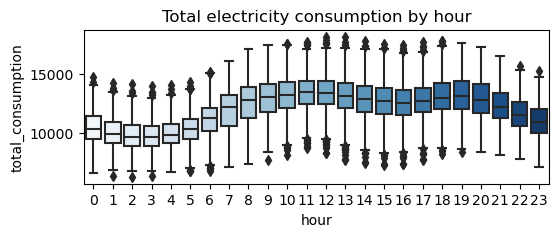

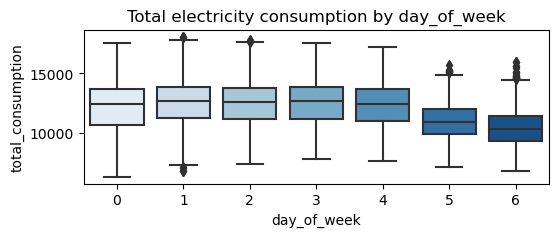

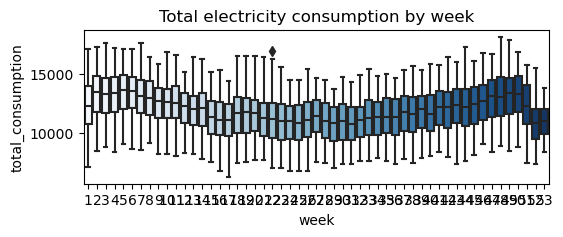

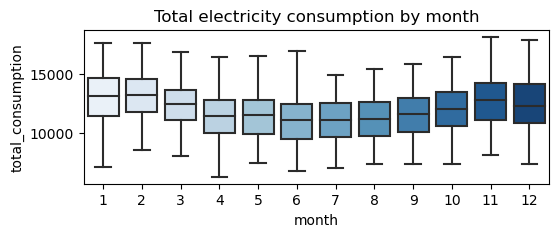

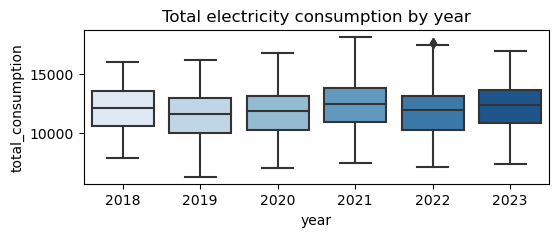

In [15]:
plot_consumption(consumption_train, "hour")
plot_consumption(consumption_train, "day_of_week")
plot_consumption(consumption_train, "week")
plot_consumption(consumption_train, "month")
plot_consumption(consumption_train, "year")

#### Step 2: Grid search with cross-validation

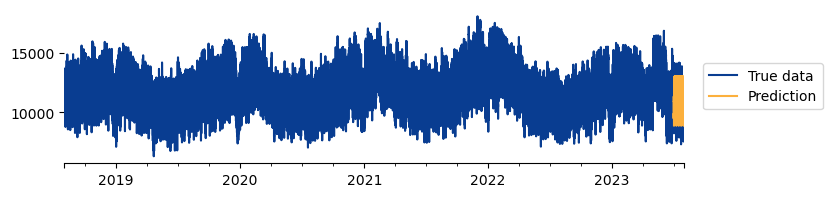

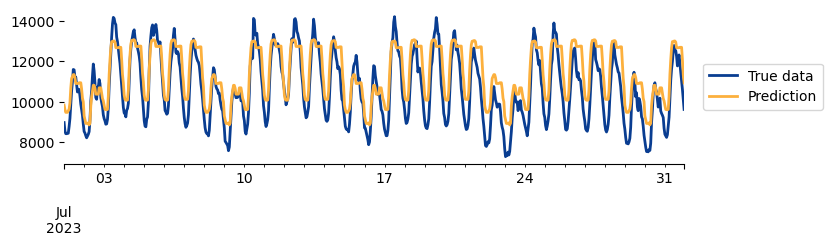

In [16]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
consumption_features = ['hour', 'day_of_week', 'week', 'month', 'day_of_year', 'year']

mname = "consumption_xgboost_cv_5years"

if LOAD_FROM_FILE:
    consumption_xgb = xgb.XGBRegressor()
    consumption_xgb.load_model(f"{fpath_models}/{mname}.json")
    consumption_df_pred = make_forecast(consumption_test, consumption_xgb, true_df=consumption_df, plot_start=split_date, plot_end=end_date, target="total_consumption")
else:
    consumption_xgb, consumption_test, consumption_rmse = run_grid_search(consumption_df, consumption_train, consumption_test, consumption_features, params, target="total_consumption")
    consumption_xgb.save_model(f"{fpath_models}/{mname}.json")

## Brown Coal

In [17]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


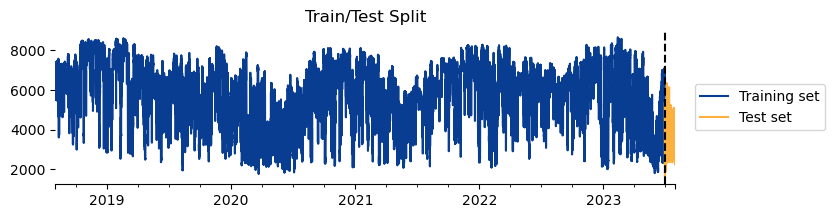

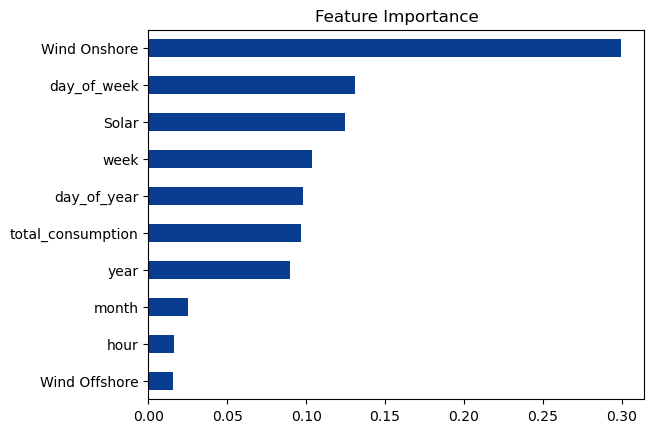

In [18]:
# Load data
brown_coal_df = pd.read_parquet(f"{fpath_data}/brown_coal_data_final_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/brown_coal_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    brown_coal_fi = pd.read_parquet(fi_path)
    brown_coal_train, brown_coal_test, brown_coal_base_xgb, brown_coal_fi = data_prep(brown_coal_df, split_date, fit_base=False, fi=brown_coal_fi)
else:
    brown_coal_train, brown_coal_test, brown_coal_base_xgb, brown_coal_fi = data_prep(brown_coal_df, split_date)
    brown_coal_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

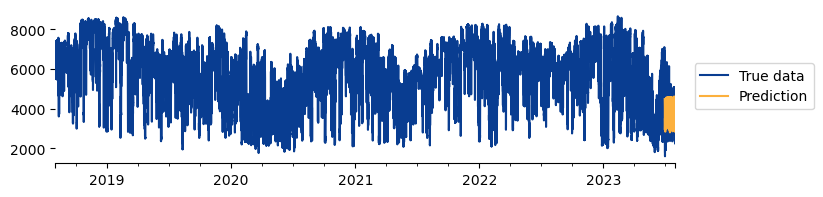

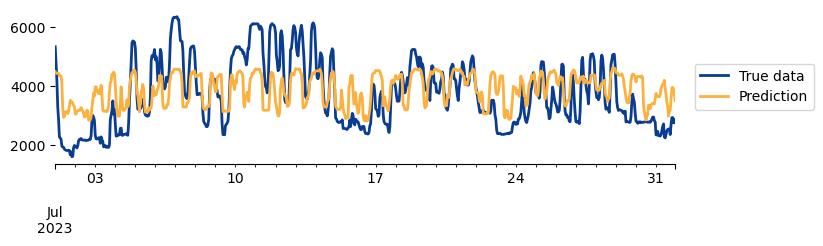

In [19]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
brown_coal_features = ['Wind Offshore', 'hour', 'month', 'year', 'total_consumption',
                       'day_of_year', 'week', 'Solar', 'day_of_week', 'Wind Onshore']

mname = "brown_coal_xgboost_cv_5years"

if LOAD_FROM_FILE:
    brown_coal_xgb = xgb.XGBRegressor()
    brown_coal_xgb.load_model(f"{fpath_models}/{mname}.json")
    brown_coal_df_pred = make_forecast(brown_coal_test, brown_coal_xgb, true_df=brown_coal_df, plot_start=split_date, plot_end=end_date)
else:
    brown_coal_xgb, brown_coal_test, brown_coal_rmse = run_grid_search(brown_coal_df, brown_coal_train, brown_coal_test, brown_coal_features, params)
    brown_coal_xgb.save_model(f"{fpath_models}/{mname}.json")

## Hard Coal

In [20]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


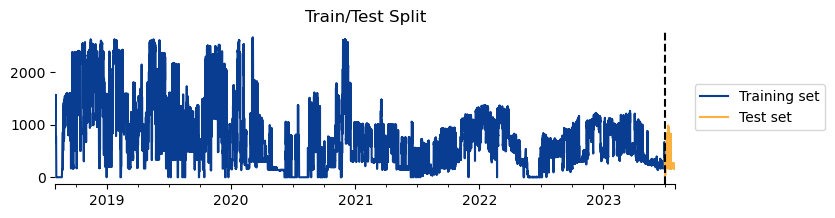

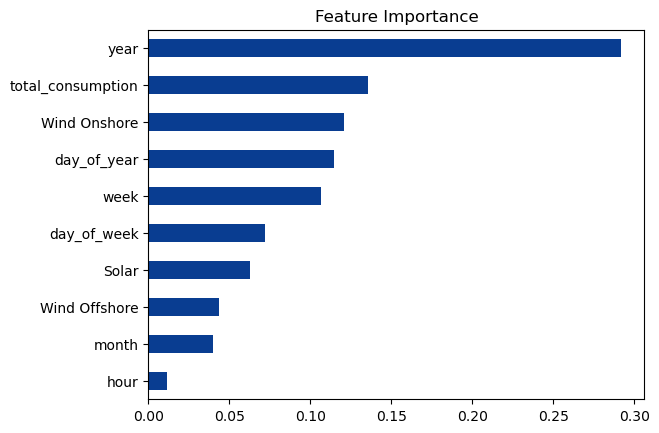

In [21]:
# Load data
hard_coal_df = pd.read_parquet(f"{fpath_data}/hard_coal_data_final_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/hard_coal_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    hard_coal_fi = pd.read_parquet(fi_path)
    hard_coal_train, hard_coal_test, hard_coal_base_xgb, hard_coal_fi = data_prep(hard_coal_df, split_date, fit_base=False, fi=hard_coal_fi)
else:
    hard_coal_train, hard_coal_test, hard_coal_base_xgb, hard_coal_fi = data_prep(hard_coal_df, split_date)
    hard_coal_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

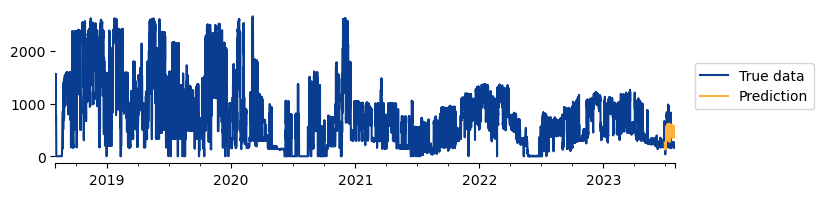

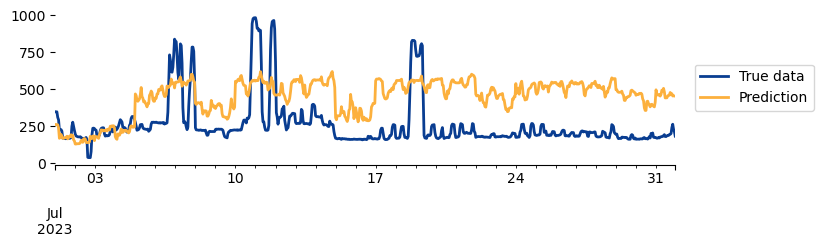

In [22]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
hard_coal_features = ['hour', 'month', 'Wind Offshore', 'Solar', 'day_of_week', 'week',
                      'day_of_year', 'Wind Onshore', 'total_consumption', 'year']

mname = "hard_coal_xgboost_cv_5years"

if LOAD_FROM_FILE:
    hard_coal_xgb = xgb.XGBRegressor()
    hard_coal_xgb.load_model(f"{fpath_models}/{mname}.json")
    hard_coal_df_pred = make_forecast(hard_coal_test, hard_coal_xgb, true_df=hard_coal_df, plot_start=split_date, plot_end=end_date)
else:
    hard_coal_xgb, hard_coal_test, hard_coal_rmse = run_grid_search(hard_coal_df, hard_coal_train, hard_coal_test, hard_coal_features, params)
    hard_coal_xgb.save_model(f"{fpath_models}/{mname}.json")

## Gas

In [23]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


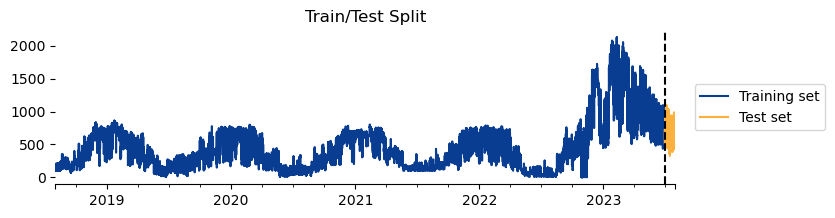

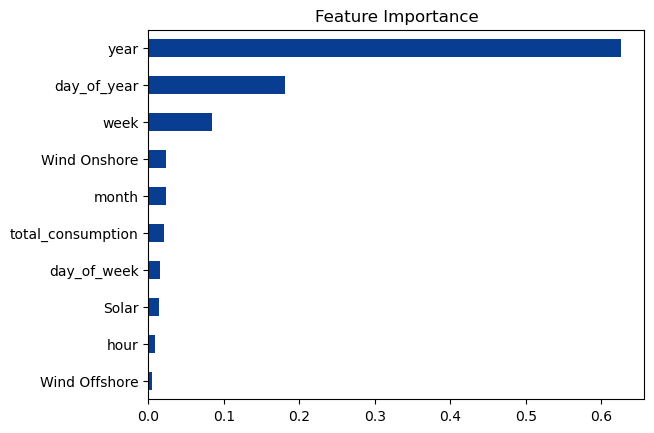

In [24]:
# Load data
gas_df = pd.read_parquet(f"{fpath_data}/gas_data_final_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/gas_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    gas_fi = pd.read_parquet(fi_path)
    gas_train, gas_test, gas_base_xgb, gas_fi = data_prep(gas_df, split_date, fit_base=False, fi=gas_fi)
else:
    gas_train, gas_test, gas_base_xgb, gas_fi = data_prep(gas_df, split_date)
    gas_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

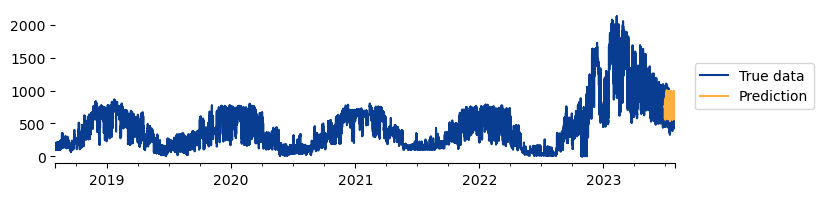

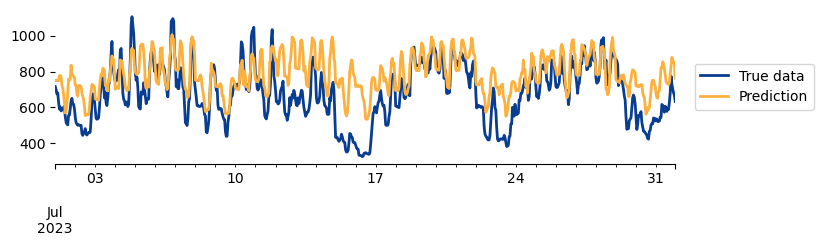

In [25]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
gas_features = ['year', 'day_of_year', 'week', 'Wind Onshore', 'month',
                'total_consumption', 'day_of_week', 'Solar', 'hour', 'Wind Offshore']

mname = "gas_xgboost_cv_5years"

if LOAD_FROM_FILE:
    gas_xgb = xgb.XGBRegressor()
    gas_xgb.load_model(f"{fpath_models}/{mname}.json")
    gas_df_pred = make_forecast(gas_test, gas_xgb, true_df=gas_df, plot_start=split_date, plot_end=end_date)
else:
    gas_xgb, gas_test, gas_rmse = run_grid_search(gas_df, gas_train, gas_test, gas_features, params)
    gas_xgb.save_model(f"{fpath_models}/{mname}.json")

## Other Fossils

In [26]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


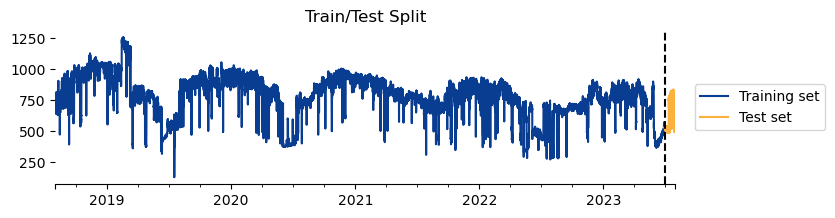

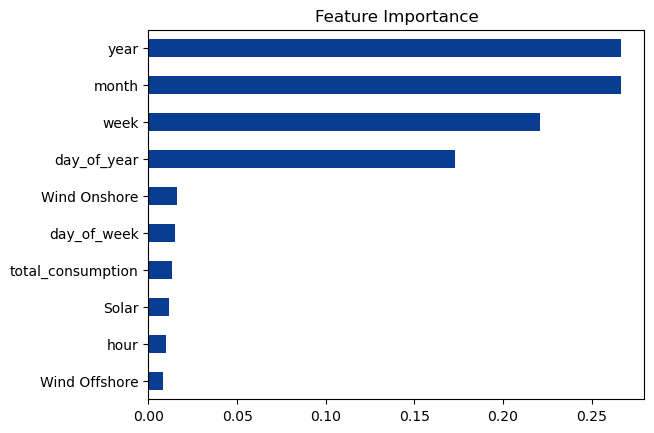

In [27]:
# Load data
other_fossils_df = pd.read_parquet(f"{fpath_data}/other_fossils_data_final_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/other_fossils_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    other_fossils_fi = pd.read_parquet(fi_path)
    other_fossils_train, other_fossils_test, other_fossils_base_xgb, other_fossils_fi = data_prep(other_fossils_df, split_date, fit_base=False, fi=other_fossils_fi)
else:
    other_fossils_train, other_fossils_test, other_fossils_base_xgb, other_fossils_fi = data_prep(other_fossils_df, split_date)
    other_fossils_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

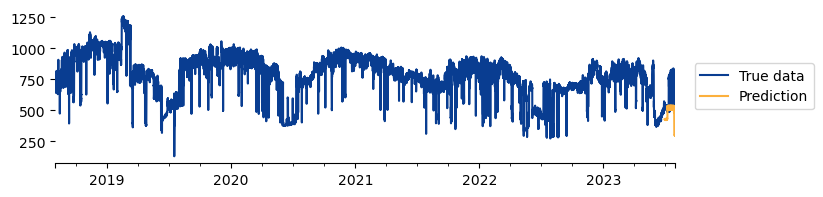

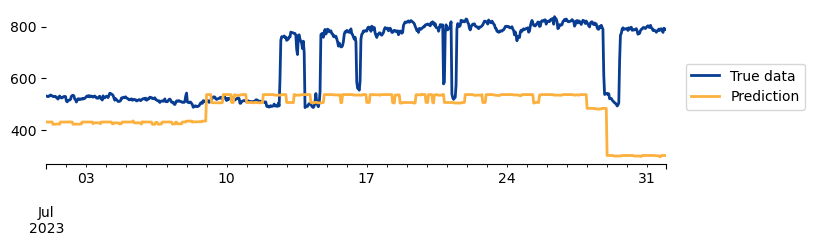

In [28]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
other_fossils_features = ['year', 'month', 'week', 'day_of_year', 'Wind Onshore', 'day_of_week',
                          'total_consumption', 'Solar', 'hour', 'Wind Offshore']

mname = "other_fossils_xgboost_cv_5years"

if LOAD_FROM_FILE:
    other_fossils_xgb = xgb.XGBRegressor()
    other_fossils_xgb.load_model(f"{fpath_models}/{mname}.json")
    other_fossils_df_pred = make_forecast(other_fossils_test, other_fossils_xgb, true_df=other_fossils_df, plot_start=split_date, plot_end=end_date)
else:
    other_fossils_xgb, other_fossils_test, other_fossils_rmse = run_grid_search(other_fossils_df, other_fossils_train, other_fossils_test, other_fossils_features, params)
    other_fossils_xgb.save_model(f"{fpath_models}/{mname}.json")

## Other Renewables

In [29]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


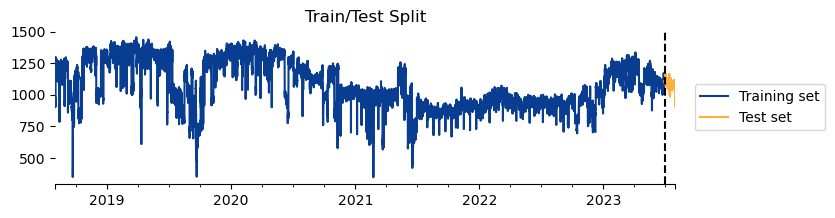

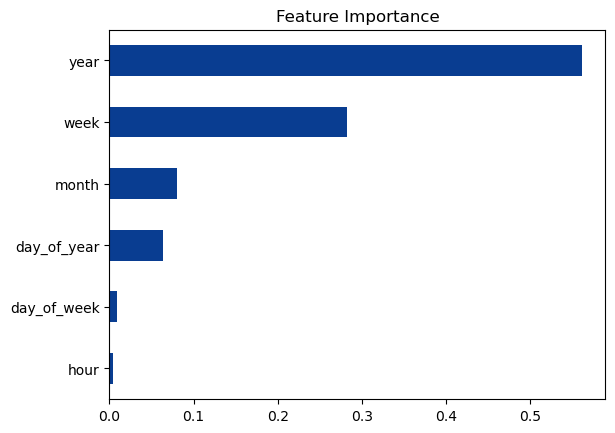

In [30]:
# Load data
other_renewables_df = pd.read_parquet(f"{fpath_data}/other_renewables_data_final_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/other_renewables_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    other_renewables_fi = pd.read_parquet(fi_path)
    other_renewables_train, other_renewables_test, other_renewables_base_xgb, other_renewables_fi = data_prep(other_renewables_df, split_date, fit_base=False, fi=other_renewables_fi)
else:
    other_renewables_train, other_renewables_test, other_renewables_base_xgb, other_renewables_fi = data_prep(other_renewables_df, split_date)
    other_renewables_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

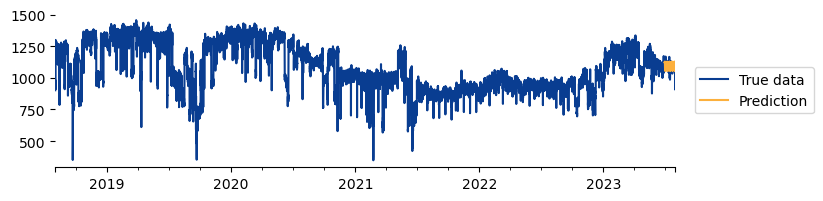

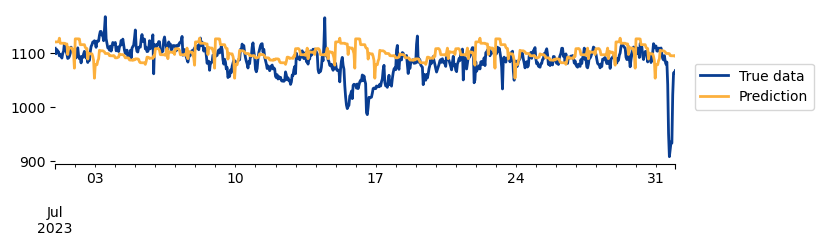

In [31]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
other_renewables_features = ['year', 'week', 'month', 'day_of_year', 'day_of_week', 'hour']

mname = "other_renewables_xgboost_cv_5years"

if LOAD_FROM_FILE:
    other_renewables_xgb = xgb.XGBRegressor()
    other_renewables_xgb.load_model(f"{fpath_models}/{mname}.json")
    other_renewables_df_pred = make_forecast(other_renewables_test, other_renewables_xgb, true_df=other_renewables_df, plot_start=split_date, plot_end=end_date)
else:
    other_renewables_xgb, other_renewables_test, other_renewables_rmse = run_grid_search(other_renewables_df, other_renewables_train, other_renewables_test, other_renewables_features, params)
    other_renewables_xgb.save_model(f"{fpath_models}/{mname}.json")

## Hydro Pumped Storage

In [32]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


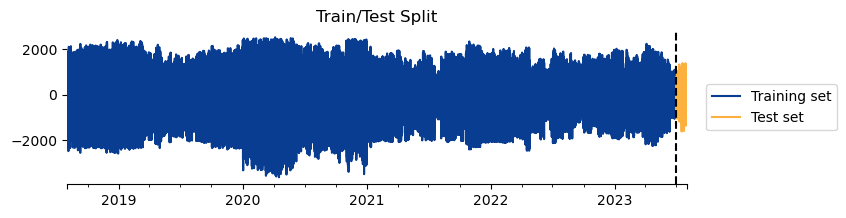

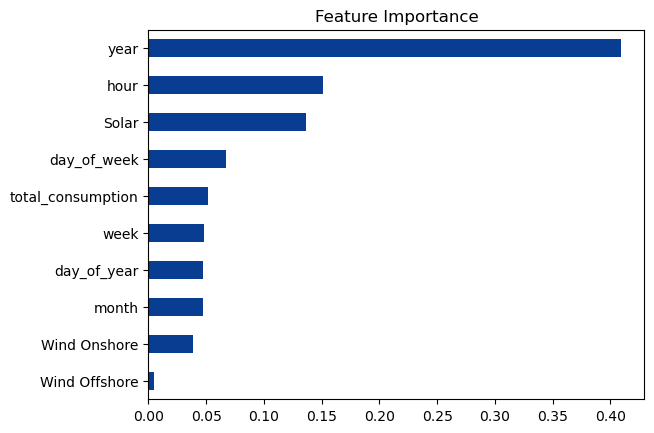

In [33]:
# Load data
hydro_pumped_storage_df = pd.read_parquet(f"{fpath_data}/hydro_pumped_storage_data_final_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/hydro_pumped_storage_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    hydro_pumped_storage_fi = pd.read_parquet(fi_path)
    hydro_pumped_storage_train, hydro_pumped_storage_test, hydro_pumped_storage_base_xgb, hydro_pumped_storage_fi = data_prep(hydro_pumped_storage_df, split_date, fit_base=False, fi=hydro_pumped_storage_fi)
else:
    hydro_pumped_storage_train, hydro_pumped_storage_test, hydro_pumped_storage_base_xgb, hydro_pumped_storage_fi = data_prep(hydro_pumped_storage_df, split_date)
    hydro_pumped_storage_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

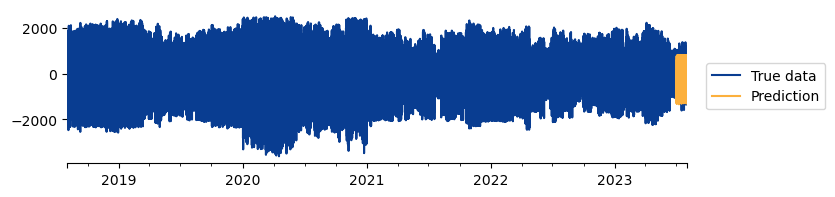

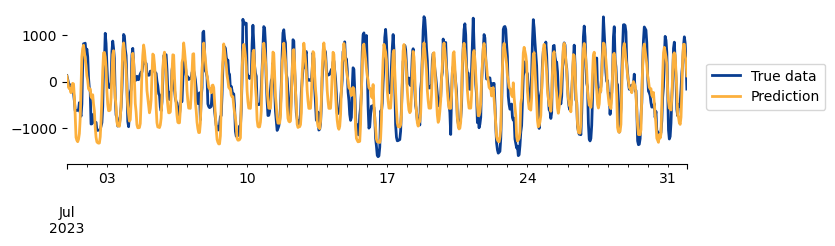

In [34]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
hydro_pumped_storage_features = ['year', 'hour', 'Solar', 'day_of_week', 'total_consumption',
                                 'day_of_year', 'month', 'week', 'Wind Onshore', 'Wind Offshore']

mname = "hydro_pumped_storage_xgboost_cv_5years"

if LOAD_FROM_FILE:
    hydro_pumped_storage_xgb = xgb.XGBRegressor()
    hydro_pumped_storage_xgb.load_model(f"{fpath_models}/{mname}.json")
    hydro_pumped_storage_df_pred = make_forecast(hydro_pumped_storage_test, hydro_pumped_storage_xgb, true_df=hydro_pumped_storage_df, plot_start=split_date, plot_end=end_date)
else:
    hydro_pumped_storage_xgb, hydro_pumped_storage_test, hydro_pumped_storage_rmse = run_grid_search(hydro_pumped_storage_df, hydro_pumped_storage_train, hydro_pumped_storage_test, hydro_pumped_storage_features, params)
    hydro_pumped_storage_xgb.save_model(f"{fpath_models}/{mname}.json")

## Price

In [35]:
LOAD_FROM_FILE = 1

#### Step 1: Prepare data

Adding datetime features... Done!
Creating train/test split... Done!


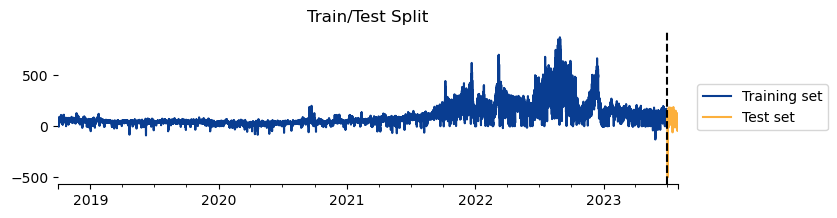

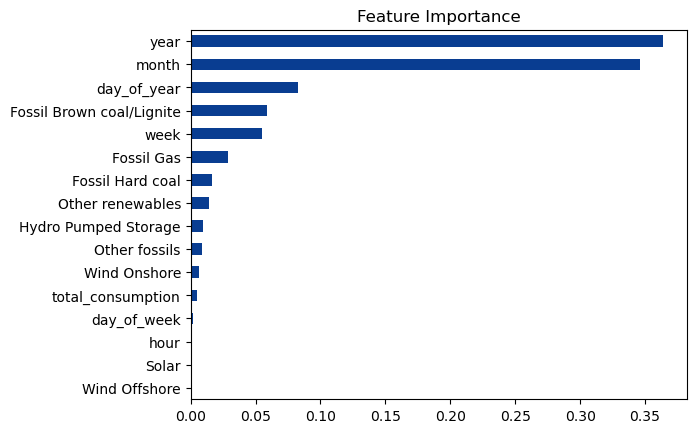

In [36]:
# Load data
price_df = pd.read_parquet(f"{fpath_data}/price_data_final_{start_date}-{end_date}.parquet")

# Prep data 
fi_path = f"{fpath_models}/price_xgb_fi.parquet" # file holding feature importance df
if LOAD_FROM_FILE:
    price_fi = pd.read_parquet(fi_path)
    price_train, price_test, price_base_xgb, price_fi = data_prep(price_df, split_date, target="prices", fit_base=False, fi=price_fi)
else:
    price_train, price_test, price_base_xgb, price_fi = data_prep(price_df, split_date, target="prices")
    price_fi.to_parquet(fi_path)

#### Step 2: Grid search with cross-validation

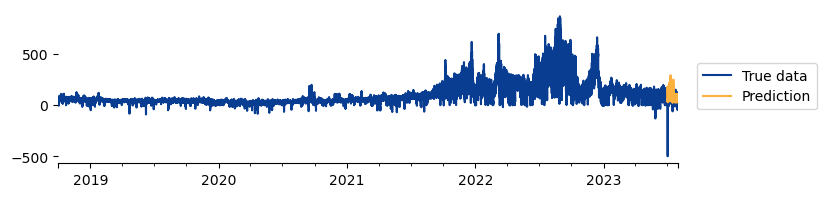

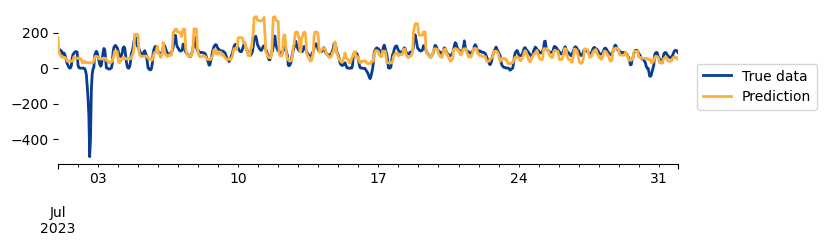

In [37]:
# Select features based on feature importance (and theoretical importance in some cases even if feature importance is small)
price_features = ['year', 'day_of_year', 'Fossil Brown coal/Lignite', 'Fossil Gas',
                  'Wind Onshore', 'Fossil Hard coal', 'month', 'week',
                  'Hydro Pumped Storage', 'Other renewables', 'day_of_week',
                  'total_consumption', 'Other fossils', 'hour', 'Solar', 'Wind Offshore']

mname = "price_xgboost_cv_5years"

if LOAD_FROM_FILE:
    price_xgb = xgb.XGBRegressor()
    price_xgb.load_model(f"{fpath_models}/{mname}.json")
    price_df_pred = make_forecast(price_test, price_xgb, true_df=price_df, plot_start=split_date, plot_end=end_date, target="prices")
else:
    price_xgb, price_test, price_rmse = run_grid_search(price_df, price_train, price_test, price_features, params, target="prices")
    price_xgb.save_model(f"{fpath_models}/{mname}.json")